# Creating Your Own Vectoriser

The ClassifAI Package is organised into three key modules, which work together to help you build and host a search engine. These are:

1. Vectorisers - Models for converting from text to vectors
2. Indexers - Classes for building vector stores from text datasets that you can search
3. Servers - Allows you to deploy a VectorStore with a RestAPI interface on a server


This notebook showcases how to create your own custom Vectoriser - we already provide several out-of-the-box Vectoriser classes for converting text to embeddings that essentially provide shortcuts for several common methods i.e. gcloud embedding services, Huggingface models, and Ollama. 

But what if you wanted to make your own custom embedding vectoriser model, that uses your own fancy embedding method....

## In this Notebook...

We will show:
* The core workings of the Vectotiser Class and its responsibilities
* How to create a custom One-Hot encoding vectoriser from scratch that will work seemlessly with the rest of the ClassifAI Package
* the custom One-Hot Encoding vectoriser being used with the Indexer module to create and search a VectorStore!

## The Vectoriser

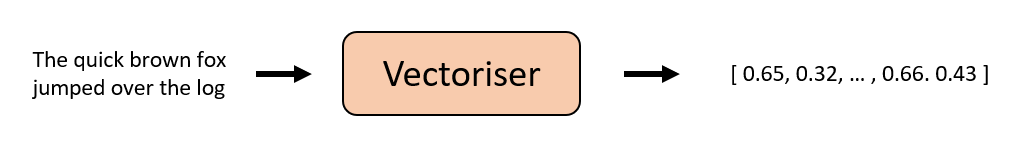

In [1]:
from IPython.display import Image, display
display(Image(filename='./files/vectoriser.png'))

As seen above, Vectorisers' sole responsibility is to convert text to a vector representation. Each Vectoriser class must implement a transform() method that will:

1. accept a string or list of N strings as an argument
2. return a numpy array of dimension [N,Y] where N matches the number of input strings, and Y is the embedding dimension)

By enforcing this interface, of having a single 'transform()' method for every vectoriser, it means that the Indexers and Servers modules cna predictably work with any Vectoriser object to perform the various search engine functions of this Package. 

Therefore, all a user has to consider when building their own vectoriser is the logic of this transform() method

## Lets build an One-Hot-Encoding Vectoriser

One-hot encoding is a simple method of converting from text to vector format. Each element in a one-hot encoded vector represents the presence or absence of a particular word in a large vocabulary. Therefore the length of the vector represents the size of the vocabulary. Each word in a sentence is transformed so that the the corresponding positional elements in the one-hot encoding vector will be set to 1. So, all sentences that contain the word 'dog' should all have the same element i of their vectors set to 1, which is the element that represents the presence of the word dog. Finally, if the converted sentence only contains 5 words, then the vector will only have 5 non-zero elements at most.

In [2]:
#we're going to use scikit learns countvectoriser to create our one hot embeddings
!pip install scikit-learn

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [3]:
#One-hot encoding vectoriser implememntation.

# 1. Class must inherit from the VectoriserBase class.
# 2. The class must implement the transform method.


#importing sklearns CountVectorizer, a common library tool for vectorisation.
from sklearn.feature_extraction.text import CountVectorizer
from classifai_package.vectorisers import VectoriserBase
import numpy as np

class OneHotVectoriser(VectoriserBase):
    def __init__(self, vocabulary: list[str]):
        if not vocabulary:
            raise ValueError("Vocabulary cannot be empty.")
        self.vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary)

    def transform(self, texts: str | list[str]) -> np.ndarray:

        #checking if the input is a string and converting to a list if so
        if isinstance(texts, str):
            texts = [texts]

        #we add some light type checking to make sure the input is correct
        if not isinstance(texts, list):
            raise TypeError("Input must be a string or a list of strings.")

        # Generate one-hot encodings using the CountVectorizer from Scikit-learn
        one_hot_matrix = self.vectorizer.transform(texts).toarray()
        return one_hot_matrix


ModuleNotFoundError: No module named 'sklearn'

We've written our custom vectoriser to accept a vocabulary as an argument during instantiation.

You could hardcode a specific vocabulary, but doing it this way would make our class reusable so that we could instantiate different OneHotVectorisers with different vocabularies

We're going to download and use Google's 10,000 most common words - a very well known file - as our vocab for our first custom one hot encoder model.

In [ ]:
import requests
import os

### First we need to download the vocabulary

# Check if the file already exists locally
if not os.path.exists("google-10000-english.txt"):

    #download file 
    url = "https://raw.github.com/first20hours/google-10000-english/master/google-10000-english.txt"
    # Path to save the file locally
    output_file = "google-10000-english.txt"

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_file, "w") as file:
            file.write(response.text)
        print(f"File downloaded and saved as {output_file}")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")



# Load vocabulary from the downloaded file
with open("google-10000-english.txt", "r") as file:
    vocabulary = [line.strip() for line in file.readlines()]

print(f"Vocabulary loaded with {len(vocabulary)} words.")
# Now we can create an instance of the OneHotVectoriser with the loaded vocabulary


Vocabulary loaded with 10000 words.


In [ ]:
# Now we can create an instance of the OneHotVectoriser with the loaded vocabulary

first_onehot_vectoriser = OneHotVectoriser(vocabulary=vocabulary)

Thats it! Lets try it out by passing some text to the transform method! 

Lets verify a few things, and ensure that the input accepts texts and lists of texts. and also that its returning the right numpy arrays!

In [ ]:
vector_one = first_onehot_vectoriser.transform("The quick brown fox jumped over the log")

print(f"One-hot vector shape: {vector_one.shape}")
print(f"One-hot vector type: {type(vector_one)}")
print("-----")
print(vector_one)

One-hot vector shape: (1, 10000)
One-hot vector type: <class 'numpy.ndarray'>
-----
[[1 0 0 ... 0 0 0]]


In [ ]:
#we can also see how many elements of the vector are non-zero (should be equal to the number of unique words in the input text)
print(f"Number of non-zero elements in the vector: {np.count_nonzero(vector_one)}")

Number of non-zero elements in the vector: 6


In [ ]:
#We can also pass a list of strings to the transform method
vector_two = first_onehot_vectoriser.transform(["The quick brown fox jumped over the log", "Slow and steady wins the race"])
print(f"One-hot vector shape: {vector_two.shape}")
print(f"One-hot vector type: {type(vector_two)}")
print("-----")
print(vector_two)

One-hot vector shape: (2, 10000)
One-hot vector type: <class 'numpy.ndarray'>
-----
[[1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]]


## Lets Use One-Hot-Encoding Vectoriser to create a VectorStore!

If you followed along with the code above, you should now have a custom vectoriser in memory and it should be fully compatiable with the rest of the Package.

We are now going to steal the second section of the oo_prototype_demo.ipynb script and build a VectorStore with the 'data/testdata.csv' file.

In [ ]:
from classifai_package.indexers import VectorStore


my_vector_store = VectorStore(
    file_name="data/testdata.csv",
    data_type="csv",
    vectoriser=first_onehot_vectoriser, #or switch to the GcpVectoriser if you have it :)
    batch_size=10,
    overwrite=True
)

INFO - No output directory specified, attempting to use input file name as output folder name.
INFO - Processing file: data/testdata.csv...

100%|██████████| 9/9 [00:00<00:00, 3511.51it/s]
INFO - Gathering metadata and saving vector store / metadata...
INFO - Vector Store created - files saved to testdata


We've build a vector store! Now to search it with a query

In [ ]:
onehot_search_results = my_vector_store.search("Places with a vast delta")

onehot_search_results



query_id,query_text,doc_id,doc_text,rank,score
i64,str,str,str,i64,f64
0,"""Places with a vast delta""","""1085""","""The delta is vast.""",0,2.0
0,"""Places with a vast delta""","""1041""","""The savanna is vast.""",1,1.0
0,"""Places with a vast delta""","""1029""","""The desert is vast.""",2,1.0
0,"""Places with a vast delta""","""1045""","""The delta is fertile.""",3,1.0
0,"""Places with a vast delta""","""1100""","""The plateau is elevated.""",4,0.0
0,"""Places with a vast delta""","""1040""","""The plateau is flat.""",5,0.0
0,"""Places with a vast delta""","""1042""","""The tundra is cold.""",6,0.0
0,"""Places with a vast delta""","""1037""","""The island is isolated.""",7,0.0
0,"""Places with a vast delta""","""1036""","""The canyon is breathtaking.""",8,0.0


## That's it!

That's everything these is to it. By implementing the transform method that:

* Accepts strings or a list of srings
* And returns a numpy array

we can create our own custom vectoriser such as the one-hot encoding model shown here. Check out the other DEMO notebooks to see how use the Vectorstore and Vectorisers in other ways and how to deploy your search system over a RestAPI service :)